# Python example

Dataset description can be found here: https://zeileis.r-universe.dev/AER/doc/manual.html#Affairs. The variable of interest is `affairs`: How often engaged in extramarital sexual intercourse during the past year? 0 = none, 1 = once, 2 = twice, 3 = 3 times, 7 = 4–10 times, 12 = monthly, 12 = weekly, 12 = daily. We'd like to explain the average frequency of `affairs`, based on gender, age, number of children, religiousness, etc.


## 1 - Install and import packages


In [ ]:
!pip install -U pandas-profiling mlsauce

In [ ]:
!pip install nnetsauce the-teller

In [ ]:
!pip install imbalanced-learn

In [4]:
# Standard Library Imports
from pathlib import Path

# Installed packages
import numpy as np
import pandas as pd
import mlsauce as ms
import nnetsauce as ns
import teller as tr

from collections import Counter
from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from time import time
from imblearn.over_sampling import RandomOverSampler

## 2 - Import data

In [5]:
# Affairs dataset
df = ms.download(pkgname="AER", dataset="Affairs", source="https://zeileis.r-universe.dev/")
print(f"===== df: \n {df} \n")
print(f"===== df.dtypes: \n {df.dtypes}")

===== df: 
      affairs  gender   age  yearsmarried children  religiousness  education  \
0          0    male 37.00         10.00       no              3         18   
1          0  female 27.00          4.00       no              4         14   
2          0  female 32.00         15.00      yes              1         12   
3          0    male 57.00         15.00      yes              5         18   
4          0    male 22.00          0.75       no              2         17   
..       ...     ...   ...           ...      ...            ...        ...   
596        1    male 22.00          1.50      yes              1         12   
597        7  female 32.00         10.00      yes              2         18   
598        2    male 32.00         10.00      yes              2         17   
599        2    male 22.00          7.00      yes              3         18   
600        1  female 32.00         15.00      yes              3         14   

     occupation  rating  
0            

In [6]:
# Generate the Profiling Report
profile = ProfileReport(
    df, title="Affairs Dataset", html={"style": {"full_width": True}}, sort=None
)

In [7]:
# The HTML report in an iframe
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3 - Model training

In [8]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
df_char_encoded = encoder.fit_transform(df[['gender', 'children']])
df_char_encoded.drop(columns = ['gender_female', 'children_no'], axis=1, inplace=True)
df_char_encoded

,gender_male,children_yes
0,1.00,0.00
1,0.00,0.00
2,0.00,1.00
3,1.00,1.00
4,1.00,0.00
...,...,...
596,1.00,1.00
597,0.00,1.00
598,1.00,1.00
599,1.00,1.00


In [9]:
df_minus_char = df.drop(columns=['affairs', 'gender', 'children'])
df_minus_char

,age,yearsmarried,religiousness,education,occupation,rating
0,37.00,10.00,3,18,7,4
1,27.00,4.00,4,14,6,4
2,32.00,15.00,1,12,1,4
3,57.00,15.00,5,18,6,5
4,22.00,0.75,2,17,6,3
...,...,...,...,...,...,...
596,22.00,1.50,1,12,2,5
597,32.00,10.00,2,18,5,4
598,32.00,10.00,2,17,6,5
599,22.00,7.00,3,18,6,2


In [10]:
X = pd.concat((df_minus_char, df_char_encoded), axis=1)
y = np.float64(df['affairs'].values)

In [11]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

In [12]:
display(Counter(y))
display(Counter(y_res))

Counter({0.0: 451, 3.0: 19, 7.0: 42, 12.0: 38, 1.0: 34, 2.0: 17})

Counter({0.0: 451, 3.0: 451, 7.0: 451, 12.0: 451, 1.0: 451, 2.0: 451})

In [13]:
# split data into training test and test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.2, random_state=13)

In [14]:
X_train

,age,yearsmarried,religiousness,education,occupation,rating,gender_male,children_yes
513,32.00,4.00,3,18,5,2,0.00,1.00
1964,37.00,15.00,2,17,6,4,0.00,1.00
836,22.00,1.50,1,12,2,5,1.00,1.00
2444,27.00,1.50,3,17,5,4,1.00,1.00
2640,32.00,10.00,3,17,5,2,0.00,1.00
...,...,...,...,...,...,...,...,...
1780,22.00,1.50,1,14,3,2,1.00,0.00
866,22.00,1.50,2,14,1,5,0.00,1.00
74,32.00,15.00,1,14,5,5,1.00,1.00
2224,32.00,4.00,3,18,5,2,0.00,1.00


In [15]:
regr = ExtraTreesRegressor(random_state=13)

start = time()
regr.fit(X_train, y_train)
print(f"\nElapsed {time() - start}")

preds = regr.predict(X_test)

# Test set RMSE
print(np.sqrt(np.mean(np.square(y_test - preds))))


Elapsed 0.9827044010162354
1.1451655681097892


## 4 - Explaining model's "decisions"

In [16]:
# creating the explainer
expr0 = tr.Explainer(obj=regr)
expr0

Explainer(obj=ExtraTreesRegressor(random_state=13))

In [17]:
start = time()
# creating an Explainer for the fitted object `regr1`
expr = tr.Explainer(obj=regr, n_jobs=-1)
# covariates' effects
expr.fit(X_test.values, y_test, X_names=X_test.columns.to_list(), method="ci")
# summary of results
expr.summary()
# timing
print(f"\n Elapsed: {time()-start}")



Calculating the effects...


100%|██████████| 542/542 [01:49<00:00,  4.95it/s]






Score (rmse): 
 1.145


Residuals: 
   Min   1Q  Median   3Q  Max
-12.00 0.00    0.00 0.00 1.33


Tests on marginal effects (Jackknife): 
              Estimate Std. Error 95% lbound 95% ubound Pr(>|t|)     
gender_male       0.31       0.05       0.21       0.42     0.00  ***
yearsmarried      0.20       0.02       0.15       0.24     0.00  ***
education         0.15       0.04       0.07       0.24     0.00  ***
occupation       -0.04       0.03      -0.11       0.02     0.19    -
age              -0.06       0.01      -0.08      -0.04     0.00  ***
children_yes     -0.24       0.06      -0.36      -0.13     0.00  ***
religiousness    -0.25       0.06      -0.36      -0.14     0.00  ***
rating           -0.33       0.07      -0.47      -0.19     0.00  ***


Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘-’ 1


Multiple R-squared:  0.92,	Adjusted R-squared:  0.919

 Elapsed: 110.05836153030396


## 5 - Prediction interval on test set

In [18]:
pi = tr.PredictionInterval(regr, method="splitconformal", level=0.95)
pi.fit(X_train, y_train)
preds = pi.predict(X_test, return_pi=True)

In [19]:
pred = preds[0]
y_lower = preds[1]
y_upper = preds[2]

# compute and display the average coverage
print(f"coverage rate = {np.mean((y_test >= y_lower) & (y_test <= y_upper))}")

coverage rate = 0.966789667896679


In [20]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')


split_color = 'tomato'
local_color = 'gray'

%matplotlib inline
np.random.seed(1)


def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title=""):

    fig = plt.figure()

    plt.plot(x, y, 'k.', alpha=.3, markersize=10,
             fillstyle='full', label=u'Test set observations')

    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_u, y_l[::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' Prediction interval')

    if pred is not None:
        plt.plot(x, pred, 'k--', lw=2, alpha=0.9,
                 label=u'Predicted value')

    #plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)

    plt.show()

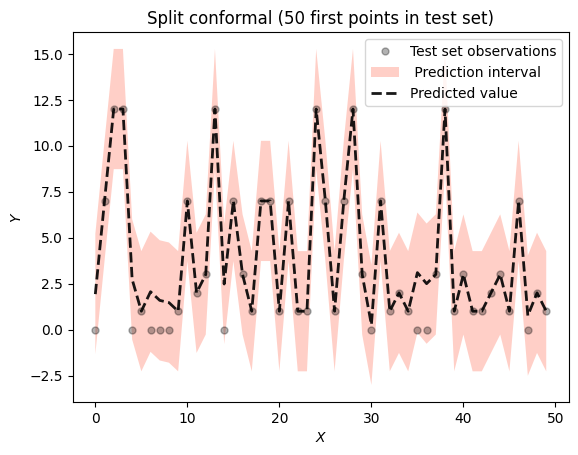

In [21]:
max_idx = 50
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = y_upper[0:max_idx],
          y_l = y_lower[0:max_idx],
          pred = pred[0:max_idx],
          shade_color=split_color,
          title = f"Split conformal ({max_idx} first points in test set)")

# R example

In [22]:
%load_ext rpy2.ipython

In [ ]:
%%R
utils::install.packages("remotes")
utils::install.packages("pscl")
utils::install.packages("skimr")
remotes::install_github("Techtonique/mlsauce_r") # this may not work on windows, try Windows WSL

library(mlsauce)

Affairs <- mlsauce::download(pkgname = "AER",
                    dataset = "Affairs",
                    source = "https://zeileis.r-universe.dev/")
skimr::skim(Affairs)

```R
── Data Summary ────────────────────────
                           Values
Name                       Affairs
Number of rows             601    
Number of columns          9      
_______________________           
Column type frequency:            
  character                2      
  numeric                  7      
________________________          
Group variables            None   

── Variable type: character ─────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 gender                0             1   4   6     0        2          0
2 children              0             1   2   3     0        2          0

── Variable type: numeric ───────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean   sd     p0 p25 p50 p75 p100 hist
1 affairs               0             1  1.46 3.30  0       0   0   0   12 ▇▁▁▁▁
2 age                   0             1 32.5  9.29 17.5    27  32  37   57 ▃▇▂▂▁
3 yearsmarried          0             1  8.18 5.57  0.125   4   7  15   15 ▆▅▃▃▇
4 religiousness         0             1  3.12 1.17  1       2   3   4    5 ▂▇▆▇▃
5 education             0             1 16.2  2.40  9      14  16  18   20 ▁▂▆▇▇
6 occupation            0             1  4.19 1.82  1       3   5   6    7 ▅▂▂▇▆
7 rating                0             1  3.93 1.10  1       3   4   5    5 ▁▂▃▇▇
```